In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 

DataTransformerRegistry.enable('json')

# Inputs

In [2]:
start_date = '20221130'
end_date = '20230517'

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

In [4]:
tidy_df_30Min[tidy_df_30Min.variable.str.startswith('spd_')].variable.unique()

array(['spd_10m_c', 'spd_10m_d', 'spd_10m_ue', 'spd_10m_uw', 'spd_15m_c',
       'spd_1m_d', 'spd_1m_ue', 'spd_1m_uw', 'spd_20m_c', 'spd_2m_c',
       'spd_3m_c', 'spd_3m_d', 'spd_3m_ue', 'spd_3m_uw', 'spd_5m_c'],
      dtype=object)

The velocity profile during neutral conditions is 

$$\overline{u} = \frac{u_*}{k} ln(z / z_0)$$

or

$$\overline{u} = \frac{u_*}{k} ln(z) - \frac{u_*}{k}ln(z_0)$$

or

$$\frac{k}{u_*} \overline{u} = ln(z) - ln(z_0)$$

In [5]:
neutral_timestamps = tidy_df_30Min.query("variable == 'Ri_3m_c'").query("value < 0.25").query("value > -0.25").time

VON_KARMAN = 0.4

fit_data = tidy_df_30Min[tidy_df_30Min.variable.isin([
    'spd_2m_c',
    'spd_3m_c',
    'spd_15m_c',
    'spd_20m_c',
    
    'u*_2m_c',
    'u*_3m_c',
    'u*_15m_c',
    'u*_20m_c',
])]

fit_data = fit_data[fit_data.time.isin(neutral_timestamps)]

# fit_data = fit_data.pivot_table(
#     values = 'value',
#     index = 'time',
#     columns='variable'
# ).reset_index()

In [6]:
src = fit_data[fit_data.time == fit_data.time.min()]

wind_speed = src.query("measurement == 'wind speed'").sort_values("height")['value']

shear_velocity = src.query("measurement == 'shear velocity'").sort_values("height")['value']
height = src.query("measurement == 'wind speed'").sort_values("height")['height']

In [7]:
y = wind_speed.values
x = VON_KARMAN*shear_velocity.values*np.log(height.values)

x, y

(array([0.08868503, 0.1362764 , 0.37760024, 0.49852509]),
 array([3.13829299, 3.32342617, 3.91653144, 3.87715062]))

In [8]:
slope, intercept = np.polyfit(x, y, deg=1)

In [9]:
import matplotlib.pyplot as plt

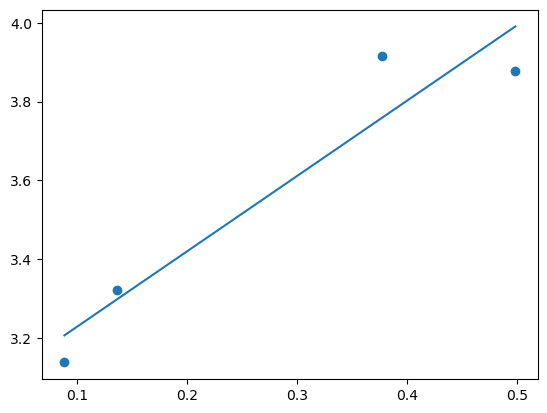

In [10]:
plt.scatter(x,y)
domain = np.linspace(x.min(), x.max())
range = [slope*v + intercept for v in domain]
plt.plot(domain, range)

In [11]:
slope, intercept

(1.9122818591382347, 3.037453246414311)

If our calculated intercept, $i$ is 

$$i = - \frac{u_*}{k}ln(z_0)$$

Then we can solve for $z_0$,

$$z_0 = exp\Big(\frac{-i*k}{u_*}\Big)$$

In [12]:
np.exp(-intercept*VON_KARMAN / shear_velocity.mean())

0.030658911127722635